In [1]:
import nltk
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Imports - our files
import utils
import models

# Global definitions - data
DATA_FN = 'data/crowdflower_data.csv'
LABEL_NAMES = ["happiness", "worry", "neutral", "sadness"]

# Global definitions - architecture
EMBEDDING_DIM = 100  # We will use pretrained 100-dimensional GloVe
BATCH_SIZE = 128
NUM_CLASSES = 4
USE_CUDA = torch.cuda.is_available()  # CUDA will be available if you are using the GPU image for this homework

# Global definitions - saving and loading data
FRESH_START = False  # set this to false after running once with True to just load your preprocessed data from file
#                     (good for debugging)
TEMP_FILE = "temporary_data.pkl"  # if you set FRESH_START to false, the program will look here for your data, etc.

In [2]:
# load the data and embeddings from file
try:
    with open(TEMP_FILE, "rb") as f:
        print("Loading DataLoaders and embeddings from file....")
        train_generator, dev_generator, test_generator, embeddings, train_data = pickle.load(f)
except FileNotFoundError:
    raise FileNotFoundError("You need to have saved your data with FRESH_START=True once in order to load it!")

Loading DataLoaders and embeddings from file....


In [3]:
class DenseNetwork(nn.Module):
    def __init__(self, embed_dim, output_dim, hidden_dim, weight):
        super(DenseNetwork, self).__init__()

        ########## YOUR CODE HERE ##########
        # TODO: Here, create any layers and attributes your network needs.
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.dense1 = nn.Linear(embed_dim, hidden_dim) 
        self.dense2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()     

    def forward(self, x):
        ########## YOUR CODE HERE ##########
        # TODO: Fill in the forward pass of your neural network.
        # TODO: (The backward pass will be performed by PyTorch magic for you!)
        # TODO: Your architecture should...
        # TODO: 1) Put the words through an Embedding layer (which was initialized with the pretrained embeddings);
        x = self.embedding(x)
        # TODO: 2) Take the sum of all word embeddings in a sentence
        x = torch.sum(x,dim=1).float()
        # TODO: 3) Feed the result into 2-layer feedforward network which produces a 4-vector of values,
        # TODO: one for each class
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        return x
        
net = DenseNetwork(EMBEDDING_DIM, NUM_CLASSES, 64, embeddings)
print(net)

DenseNetwork(
  (embedding): Embedding(17635, 100)
  (dense1): Linear(in_features=100, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)


In [10]:
HIDDEN_DIM = 64
model = DenseNetwork(EMBEDDING_DIM, NUM_CLASSES, HIDDEN_DIM, embeddings)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
  
EPOCHS = 20
losses = []
for iepoch in range(EPOCHS): 
    for train_batch, train_label in train_generator:
        # Compute the loss
        loss = criterion(model(train_batch),train_label)

        # Zero the gradients
        model.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

    total_loss = 0
    for ibatch, ilabel in dev_generator:
        dev_loss = criterion(model(ibatch), ilabel)
        total_loss += dev_loss
    print(iepoch, total_loss)
    losses.append(total_loss)
    if iepoch > 1 and losses[-2]-total_loss < 0.01:
        break
MODEL_PATH = 'dense.pth'
torch.save(model, MODEL_PATH)

0 tensor(26.8822, grad_fn=<AddBackward0>)
1 tensor(26.3045, grad_fn=<AddBackward0>)
2 tensor(26.0139, grad_fn=<AddBackward0>)
3 tensor(25.8493, grad_fn=<AddBackward0>)
4 tensor(25.7613, grad_fn=<AddBackward0>)
5 tensor(25.7190, grad_fn=<AddBackward0>)
6 tensor(25.6867, grad_fn=<AddBackward0>)
7 tensor(25.6644, grad_fn=<AddBackward0>)
8 tensor(25.6878, grad_fn=<AddBackward0>)


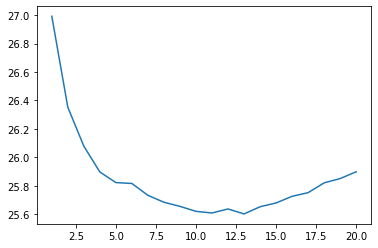

In [6]:
import matplotlib.pyplot as plt
x = np.arange(1,EPOCHS+1)
plt.plot(x, losses)
plt.show()

In [11]:
test = torch.load(MODEL_PATH)
test.eval()

DenseNetwork(
  (embedding): Embedding(17635, 100)
  (dense1): Linear(in_features=100, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)

In [ ]:
def train_model(model, loss_fn, optimizer, train_generator, dev_generator):
    """
    Perform the actual training of the model based on the train and dev sets.
    :param model: one of your models, to be trained to perform 4-way emotion classification
    :param loss_fn: a function that can calculate loss between the predicted and gold labels
    :param optimizer: a created optimizer you will use to update your model weights
    :param train_generator: a DataLoader that provides batches of the training set
    :param dev_generator: a DataLoader that provides batches of the development set
    :return model, the trained model
    """
    
    
    for epoch in range(50):
        # Forward Propagation
        y_pred = model(x)
        # Compute and print loss
        loss = criterion(y_pred, y)
        print('epoch: ', epoch,' loss: ', loss.item())
        # Zero the gradients
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

In [12]:
def test_model(model, loss_fn, test_generator):
    """
    Evaluate the performance of a model on the development set, providing the loss and macro F1 score.
    :param model: a model that performs 4-way emotion classification
    :param loss_fn: a function that can calculate loss between the predicted and gold labels
    :param test_generator: a DataLoader that provides batches of the testing set
    """
    gold = []
    predicted = []

    # Keep track of the loss
    loss = torch.zeros(1)  # requires_grad = False by default; float32 by default
    if USE_CUDA:
        loss = loss.cuda()

    model.eval()

    # Iterate over batches in the test dataset
    with torch.no_grad():
        for X_b, y_b in test_generator:
            # Predict
            y_pred = model(X_b)

            # Save gold and predicted labels for F1 score - take the argmax to convert to class labels
            gold.extend(y_b.cpu().detach().numpy())
            predicted.extend(y_pred.argmax(1).cpu().detach().numpy())

            loss += loss_fn(y_pred.double(), y_b.long()).data

    # Print total loss and macro F1 score
    print("Test loss: ")
    print(loss)
    print("F-score: ")
    print(f1_score(gold, predicted, average='macro'))

test_model(test, criterion, test_generator)

Test loss: 
tensor([25.5388])
F-score: 
0.43862077298370256
